In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib
matplotlib.rc('font', family='AppleGothic')
matplotlib.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# 그래프 틀 변경
plt.rcParams['axes.unicode_minus'] = False
sns.set(font_scale = 1)  
plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_columns', None)

In [2]:
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import ( LSTM,
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.dropna(how = 'any', axis =1)
train['text_len']  = train['text'].apply(lambda x : len(x.split(' ')))

In [5]:
train.head()

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   text      7613 non-null   object
 2   target    7613 non-null   int64 
 3   text_len  7613 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 238.0+ KB


In [7]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [8]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 4 columns in train
There are 3263 rows and 4 columns in train


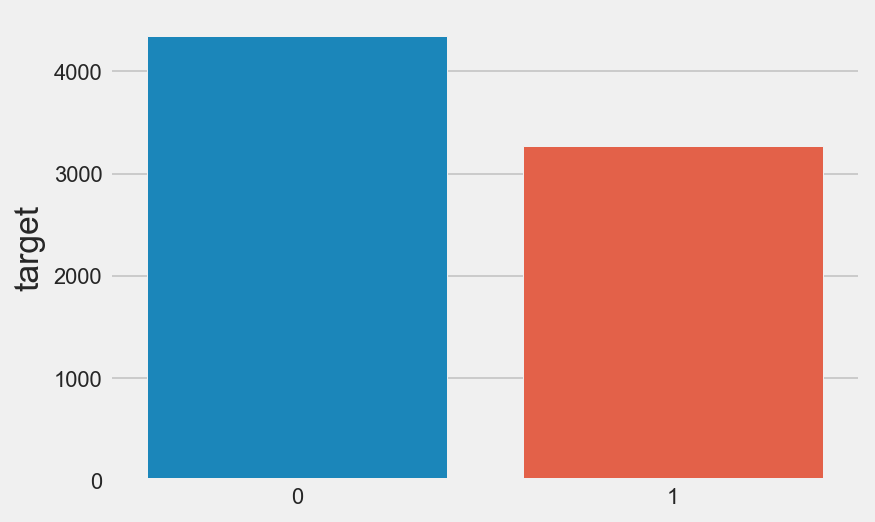

In [9]:
x = train.target.value_counts()

sns.barplot(x.index, x)
plt.show()

### EDA

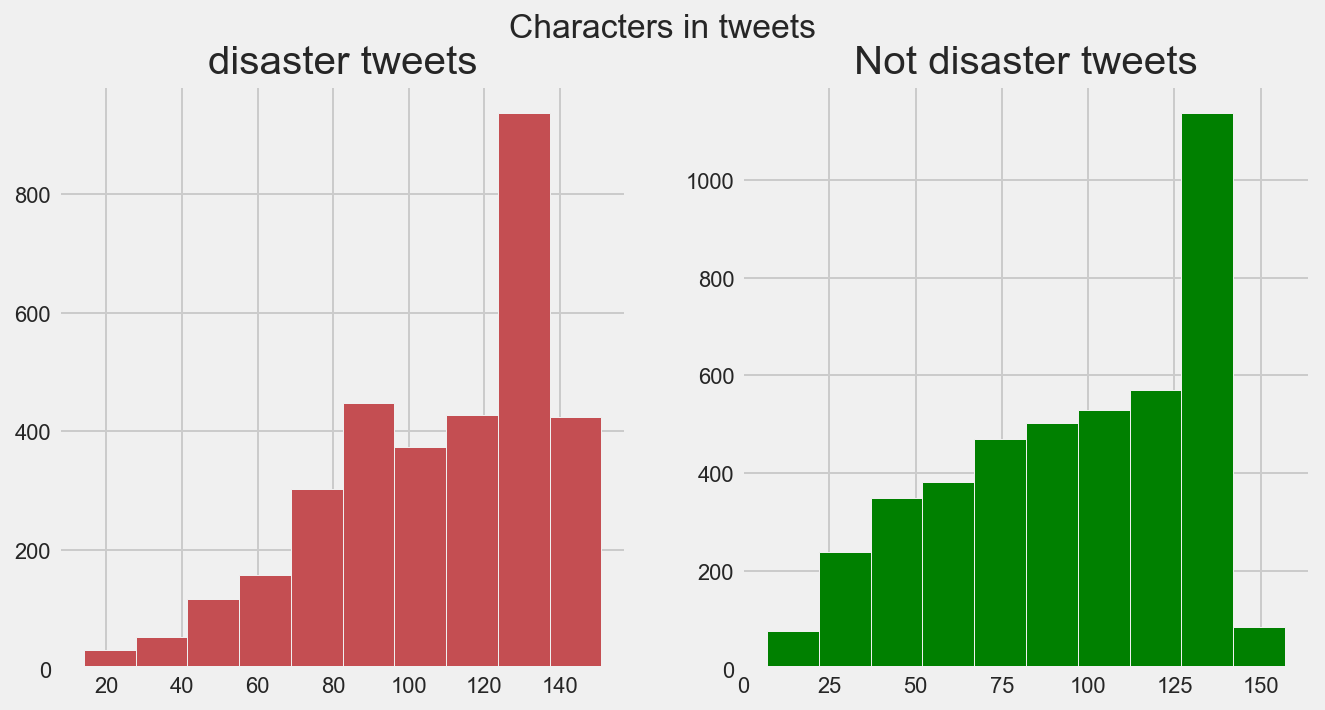

In [10]:
fig , axes = plt.subplots(1, 2, figsize = (10, 5))

t_len=train[train['target']==1]['text'].str.len()
axes[0].hist(t_len, color = 'r')
axes[0].set_title('disaster tweets')
              
t_len= train[train['target']==0]['text'].str.len()
axes[1].hist(t_len,color='green')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

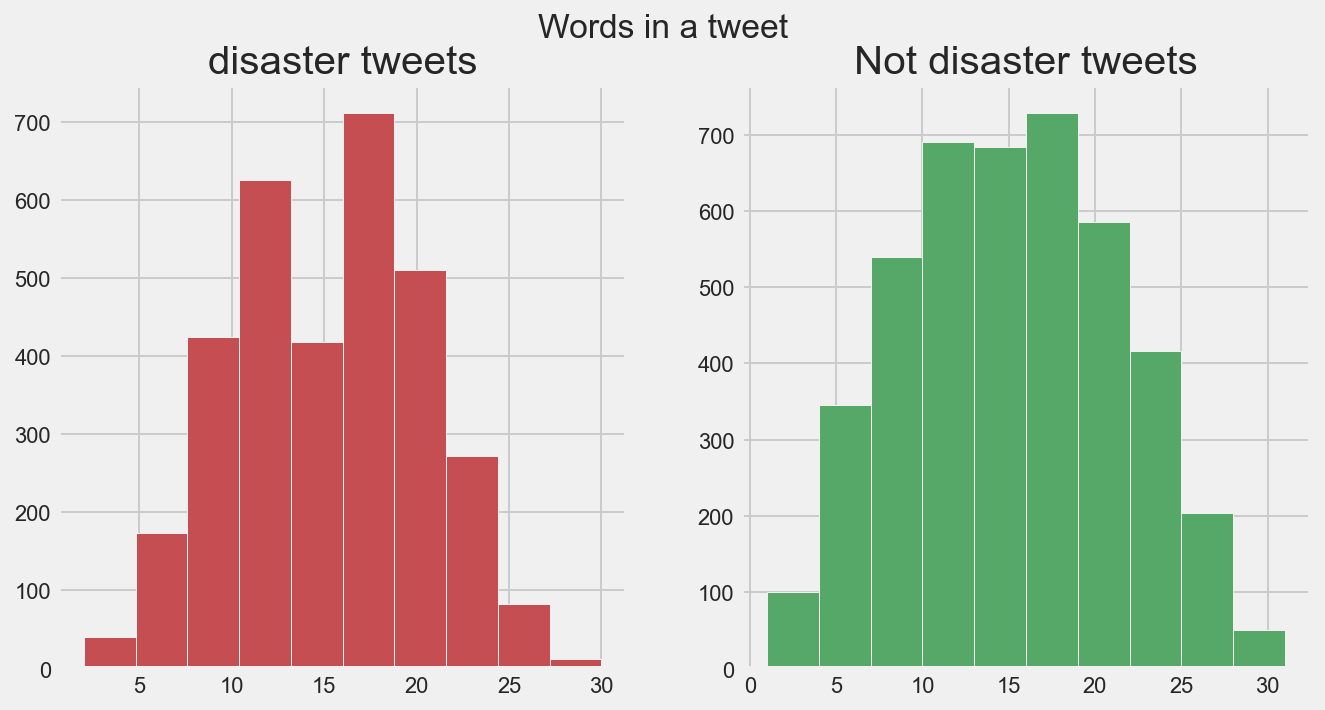

In [11]:
fig ,axes =plt.subplots(1,2 , figsize = (10, 5))

t_len = train[train['target']==1]['text'].str.split().map(lambda x : len(x))
axes[0].hist(t_len, color = 'r')
axes[0].set_title('disaster tweets')

t_len = train[train['target']==0]['text'].str.split().map(lambda x : len(x))
axes[1].hist(t_len, color = 'g')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


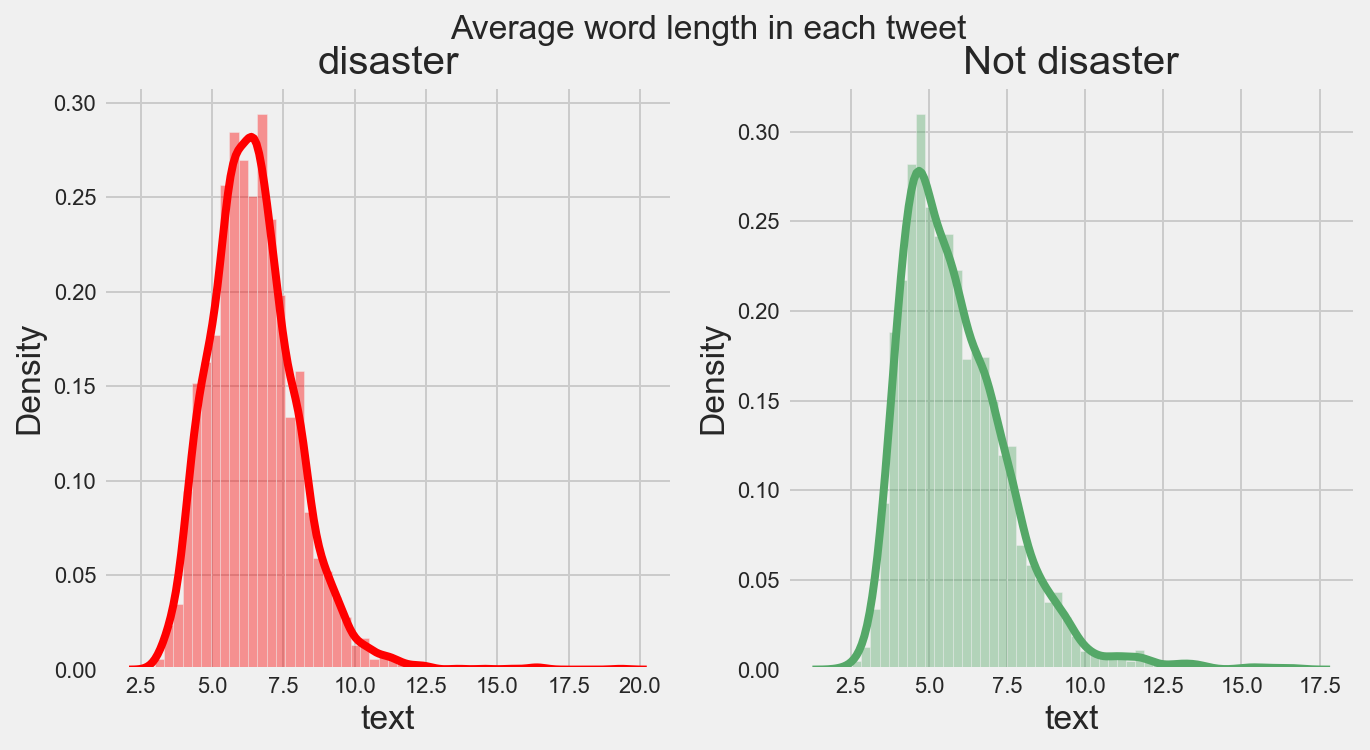

In [12]:
fig, axes = plt.subplots(1,2 , figsize = (10,5))

w = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(w.map(lambda x: np.mean(x)),ax=axes[0],color='red')
axes[0].set_title('disaster')

w = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(w.map(lambda x: np.mean(x)),ax=axes[1],color='g')
axes[1].set_title('Not disaster')
fig.suptitle('Average word length in each tweet')
plt.show()

### Data preprocessing

In [24]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
  
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [25]:
# test 
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [26]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text


In [27]:
test['cleaned_text'] = test['text'].apply(preprocess_data)

train['cleaned_text'] = train['text'].apply(preprocess_data)

In [28]:
train.head(3)

,id,text,target,text_len,cleaned_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...


### Modeling

In [29]:
x = train['cleaned_text']
y = train['target']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 3)

In [31]:
print(len(x_train ), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [44]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [33]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

### Naive Bayes DTM

In [37]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [38]:
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [42]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.789390756302521


In [43]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.8493368788988678

### Naive Bayes 

In [45]:
pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

In [46]:
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))


0.7925420168067226


### XGB

In [47]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc'
        
    ))
])

In [48]:
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

Train: 0.8015414258188824
Test: 0.743172268907563


In [64]:
train_tweets = train['cleaned_text'].values
test_tweets = test['cleaned_text'].values
train_target = train['target'].values

In [65]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13697

In [66]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 137,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1806, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2636, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

In [67]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [69]:
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 23, 100)           1369700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 23, 46)           22816     
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 46)               0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_3 (Batc  (None, 46)               184       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 46)                0         
                                                      

In [70]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)


Epoch 1/7
179/179 [==============================] - ETA: 0s - loss: 0.7147 - accuracy: 0.6045
Epoch 1: val_loss improved from inf to 0.65058, saving model to model.h5
179/179 [==============================] - 701s 4s/step - loss: 0.7147 - accuracy: 0.6045 - val_loss: 0.6506 - val_accuracy: 0.6843 - lr: 0.0010
Epoch 2/7
179/179 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7310
Epoch 2: val_loss improved from 0.65058 to 0.55165, saving model to model.h5
179/179 [==============================] - 662s 4s/step - loss: 0.5605 - accuracy: 0.7310 - val_loss: 0.5517 - val_accuracy: 0.7626 - lr: 0.0010
Epoch 3/7
179/179 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.7805
Epoch 3: val_loss improved from 0.55165 to 0.50027, saving model to model.h5
179/179 [==============================] - 663s 4s/step - loss: 0.4932 - accuracy: 0.7805 - val_loss: 0.5003 - val_accuracy: 0.7637 - lr: 0.0010
Epoch 4/7
179/179 [==============================] - 